In [1]:
%matplotlib inline
from pathlib import Path
from cartopy import crs as ccrs
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import astropy.constants as astro
import xarray as xr
import netCDF4 as nc
import pandas as pd
import numpy as np
import scipy as sc
import os
import sys
from windrose import WindroseAxes
import matplotlib.cm as cm
from scipy import integrate
import seaborn as sns

def savefig(filename, directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        plt.savefig(directory_path + filename, facecolor='white', bbox_inches='tight')
    else:
        plt.savefig(directory_path + filename, facecolor='white', bbox_inches='tight')
        
def save_netcdf(ds, name_file, directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        ds.to_netcdf(directory_path + name_file, mode='w')
    else:
        ds.to_netcdf(directory_path + name_file, mode='w')

In [2]:
from scipy.interpolate import NearestNDInterpolator
def interpolate_field_lon_lat(field, lon_coord="clon", lat_coord="clat", relative_resolution=2):
    nlon = nlat = int(np.sqrt(len(field) * relative_resolution))  
    
    lon_points = field[lon_coord].values
    lat_points = field[lat_coord].values
    
    lon = np.linspace(np.min(lon_points), np.max(lon_points), nlon)
    lat = np.linspace(np.min(lat_points), np.max(lat_points), nlat)
    lon2, lat2 = np.meshgrid(lon, lat)
    
    points = np.stack((lon_points, lat_points), axis=1)
    return xr.DataArray(
        NearestNDInterpolator(points, field.values)(lon2, lat2),
        dims=["lat", "lon"],
        coords={"lon": lon, "lat": lat})

def interpolate_field_lon_lat_low_res(field, lon_coord="clon", lat_coord="clat", relative_resolution=0.05):
    nlon = nlat = int(np.sqrt(len(field) * relative_resolution))  # maybe make this more configurable
    
    lon_points = field[lon_coord].values
    lat_points = field[lat_coord].values
    
    lon = np.linspace(np.min(lon_points), np.max(lon_points), nlon)
    lat = np.linspace(np.min(lat_points), np.max(lat_points), nlat)
    lon2, lat2 = np.meshgrid(lon, lat)
    
    points = np.stack((lon_points, lat_points), axis=1)
    return xr.DataArray(
        NearestNDInterpolator(points, field.values)(lon2, lat2),
        dims=["lat", "lon"],
        coords={"lon": lon, "lat": lat})

In [3]:
def zonal_mean(variable, new_grid, bins):
    counts_per_bin, lat_bins = np.histogram(new_grid.clat[valid][mask], bins=bins)
    varsum_per_bin, _ = np.histogram(new_grid.clat[valid][mask], weights=variable, bins=bins)
    zonal_mean = varsum_per_bin / counts_per_bin
    return zonal_mean, lat_bins, counts_per_bin

def meridional_mean(variable, bins):
    counts_per_bin, lon_bins = np.histogram(variable.clon, bins=bins)
    varsum_per_bin, _ = np.histogram(variable.clon, weights=variable, bins=bins)
    meridional_mean = varsum_per_bin / counts_per_bin
    return meridional_mean, lon_bins, counts_per_bin

In [4]:
def get_mask(ocean_type, dpp, year, season):
    degrees_lower_box_bound, degrees_upper_box_bound, degrees_left_box_bound, degrees_right_box_bound = choose_region(ocean_type)
    new_grid  = xr.open_dataset(f"/work/mh0731/m300868/00_DATA/grid_info/new_grids/new_grid_{degrees_lower_box_bound}_{degrees_upper_box_bound}_{degrees_left_box_bound}_{degrees_right_box_bound}.nc")
    filepath  = f"/work/mh0731/m300868/00_DATA/{dpp}/09_wrapped_up_datasets/{year}/09_{dpp}_WRAPUP_dataset_region_{degrees_lower_box_bound}_{degrees_upper_box_bound}_{degrees_left_box_bound}_{degrees_right_box_bound}_year_{year}_season_{season}.nc"                    
    data      = xr.open_dataset(filepath)
    data      = xr.merge([xr.where(data['valid']==1, True, False), xr.where(data['valid_oce']==1, True, False), xr.where(data['mask']==1, True, False), xr.where(data['mask_oce']==1, True, False), data.drop({'valid', 'valid_oce', 'mask', 'mask_oce'})])
    valid     = data.valid.values
    mask      = data.mask.values
    two_to_two_mask = np.where((new_grid.sel(cell=valid).sel(cell=mask).clat < np.deg2rad(2)) & 
                               (new_grid.sel(cell=valid).sel(cell=mask).clat > np.deg2rad(-2)), True, False)
    return two_to_two_mask

In [5]:
from box_coordinates_and_paths import choose_region

ocean_type = 'western_pacific'
dpp        = 'ngc2009'
year       = '2020'
season     = "MAM"

degrees_lower_box_bound, degrees_upper_box_bound, degrees_left_box_bound, degrees_right_box_bound = choose_region(ocean_type)
print(ocean_type, 'with:', choose_region(ocean_type))

wpcf_selected_indices     = xr.open_dataset(f"/work/mh0731/m300868/00_DATA/grid_info/selected_indices/selected_indices_{degrees_lower_box_bound}_{degrees_upper_box_bound}_{degrees_left_box_bound}_{degrees_right_box_bound}.nc")
wpcf_new_grid             = xr.open_dataset(f"/work/mh0731/m300868/00_DATA/grid_info/new_grids/new_grid_{degrees_lower_box_bound}_{degrees_upper_box_bound}_{degrees_left_box_bound}_{degrees_right_box_bound}.nc")
wpcf_selected_oce_indices = xr.open_dataset(f"/work/mh0731/m300868/00_DATA/grid_info/selected_indices/selected_oce_indices_{degrees_lower_box_bound}_{degrees_upper_box_bound}_{degrees_left_box_bound}_{degrees_right_box_bound}.nc")
wpcf_new_oce_grid         = xr.open_dataset(f"/work/mh0731/m300868/00_DATA/grid_info/new_grids/new_oce_grid_{degrees_lower_box_bound}_{degrees_upper_box_bound}_{degrees_left_box_bound}_{degrees_right_box_bound}.nc")
wpcf_vertical_grid        = xr.open_dataset(f"/work/mh0731/m300868/00_DATA/grid_info/vertical_info/vertical_info_{degrees_lower_box_bound}_{degrees_upper_box_bound}_{degrees_left_box_bound}_{degrees_right_box_bound}.nc", engine='netcdf4')

western_pacific with: (-5, 5, 150, -160)


In [6]:
data = xr.open_dataset(f"/work/mh0731/m300868/00_DATA/{dpp}/09_wrapped_up_datasets/{year}/09_{dpp}_WRAPUP_dataset_region_{degrees_lower_box_bound}_{degrees_upper_box_bound}_{degrees_left_box_bound}_{degrees_right_box_bound}_year_{year}_season_{season}.nc")                      

### recovering the boolean in the valid and mask arrays
west_pcf_data = xr.merge([xr.where(data['valid']==1, True, False), xr.where(data['valid_oce']==1, True, False), xr.where(data['mask']==1, True, False), xr.where(data['mask_oce']==1, True, False), data.drop({'valid', 'valid_oce', 'mask', 'mask_oce'})])
#data

/tmp/ipykernel_3739330/2927627665.py:4: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  west_pcf_data = xr.merge([xr.where(data['valid']==1, True, False), xr.where(data['valid_oce']==1, True, False), xr.where(data['mask']==1, True, False), xr.where(data['mask_oce']==1, True, False), data.drop({'valid', 'valid_oce', 'mask', 'mask_oce'})])


In [7]:
west_pcf_two_to_two_mask = get_mask(ocean_type, dpp, year, season)

/tmp/ipykernel_3739330/957704573.py:6: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  data      = xr.merge([xr.where(data['valid']==1, True, False), xr.where(data['valid_oce']==1, True, False), xr.where(data['mask']==1, True, False), xr.where(data['mask_oce']==1, True, False), data.drop({'valid', 'valid_oce', 'mask', 'mask_oce'})])


In [8]:
wpcf_valid     = west_pcf_data.valid.values
wpcf_valid_oce = west_pcf_data.valid_oce.values

wpcf_mask      = west_pcf_data.mask.values
wpcf_mask_oce  = west_pcf_data.mask_oce.values

In [9]:
from box_coordinates_and_paths import choose_region

ocean_type = 'atlantic'
dpp        = 'ngc2009'
year       = '2020'
season     = "SON"

degrees_lower_box_bound, degrees_upper_box_bound, degrees_left_box_bound, degrees_right_box_bound = choose_region(ocean_type)
print(ocean_type, 'with:', choose_region(ocean_type))

atl_selected_indices     = xr.open_dataset(f"/work/mh0731/m300868/00_DATA/grid_info/selected_indices/selected_indices_{degrees_lower_box_bound}_{degrees_upper_box_bound}_{degrees_left_box_bound}_{degrees_right_box_bound}.nc")
atl_new_grid             = xr.open_dataset(f"/work/mh0731/m300868/00_DATA/grid_info/new_grids/new_grid_{degrees_lower_box_bound}_{degrees_upper_box_bound}_{degrees_left_box_bound}_{degrees_right_box_bound}.nc")
atl_selected_oce_indices = xr.open_dataset(f"/work/mh0731/m300868/00_DATA/grid_info/selected_indices/selected_oce_indices_{degrees_lower_box_bound}_{degrees_upper_box_bound}_{degrees_left_box_bound}_{degrees_right_box_bound}.nc")
atl_new_oce_grid         = xr.open_dataset(f"/work/mh0731/m300868/00_DATA/grid_info/new_grids/new_oce_grid_{degrees_lower_box_bound}_{degrees_upper_box_bound}_{degrees_left_box_bound}_{degrees_right_box_bound}.nc")
atl_vertical_grid        = xr.open_dataset(f"/work/mh0731/m300868/00_DATA/grid_info/vertical_info/vertical_info_{degrees_lower_box_bound}_{degrees_upper_box_bound}_{degrees_left_box_bound}_{degrees_right_box_bound}.nc", engine='netcdf4')

atlantic with: (-5, 5, -40, 10)


In [10]:
data = xr.open_dataset(f"/work/mh0731/m300868/00_DATA/{dpp}/09_wrapped_up_datasets/{year}/09_{dpp}_WRAPUP_dataset_region_{degrees_lower_box_bound}_{degrees_upper_box_bound}_{degrees_left_box_bound}_{degrees_right_box_bound}_year_{year}_season_{season}.nc")                      

### recovering the boolean in the valid and mask arrays
atl_data = xr.merge([xr.where(data['valid']==1, True, False), xr.where(data['valid_oce']==1, True, False), xr.where(data['mask']==1, True, False), xr.where(data['mask_oce']==1, True, False), data.drop({'valid', 'valid_oce', 'mask', 'mask_oce'})])
#data

/tmp/ipykernel_3739330/4178967791.py:4: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  atl_data = xr.merge([xr.where(data['valid']==1, True, False), xr.where(data['valid_oce']==1, True, False), xr.where(data['mask']==1, True, False), xr.where(data['mask_oce']==1, True, False), data.drop({'valid', 'valid_oce', 'mask', 'mask_oce'})])


In [11]:
atl_two_to_two_mask = get_mask(ocean_type, dpp, year, season)

/tmp/ipykernel_3739330/957704573.py:6: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  data      = xr.merge([xr.where(data['valid']==1, True, False), xr.where(data['valid_oce']==1, True, False), xr.where(data['mask']==1, True, False), xr.where(data['mask_oce']==1, True, False), data.drop({'valid', 'valid_oce', 'mask', 'mask_oce'})])


In [12]:
atl_valid     = atl_data.valid.values
atl_valid_oce = atl_data.valid_oce.values

atl_mask      = atl_data.mask.values
atl_mask_oce  = atl_data.mask_oce.values

In [13]:
cell_height_unmasked = atl_vertical_grid.cell_height[::-1,:][:,:][:,:]
cell_height          = atl_vertical_grid.cell_height[::-1,atl_valid][:,atl_mask][:,:]
mean_cell_height     = cell_height.mean(axis=1)
#cell_height

# Vertical Profiles

## Precipitation - ATLANTIC

In [14]:
filepath = "/work/mh0731/m300868/00_DATA/ngc2009/pr/"

In [15]:
files = [
    filepath+"ngc2009_atm_2d_30min_mean_2020_09_atlantic_1_monthly.nc",
    filepath+"ngc2009_atm_2d_30min_mean_2020_10_atlantic_1_monthly.nc",
    filepath+"ngc2009_atm_2d_30min_mean_2020_11_atlantic_1_monthly.nc"
]

pr_atl = (xr.open_mfdataset(files, combine='by_coords').mean(dim='time') * 86400).pr.compute() # mm per day !

In [16]:
pr_atl['clon'] = np.rad2deg(pr_atl.clon)
pr_atl['clat'] = np.rad2deg(pr_atl.clat)

pr_atl = pr_atl.where((pr_atl.clat > -2) & (pr_atl.clat < 2), drop=True)

In [17]:
quantile_80 = pr_atl.quantile(0.8)
pr_atl_above_80 = pr_atl.where(pr_atl > quantile_80, 0)
pr_atl_interp = interpolate_field_lon_lat(pr_atl_above_80)
pr_atl_interp_lon, pr_atl_interp_lat = np.meshgrid(pr_atl_interp.lon, pr_atl_interp.lat)

## Precipitation - WPcF

In [18]:
filepath = "/work/mh0731/m300868/00_DATA/ngc2009/pr/"

In [19]:
files = [
    filepath+"ngc2009_atm_2d_30min_mean_2020_03_western_pacific_4_monthly.nc",
    filepath+"ngc2009_atm_2d_30min_mean_2020_04_western_pacific_4_monthly.nc",
    filepath+"ngc2009_atm_2d_30min_mean_2020_05_western_pacific_4_monthly.nc"
]

pr_wpcf_west_ds = (xr.open_mfdataset(files, combine='by_coords').mean(dim='time') * 86400) # mm per day !

In [20]:
files = [
    filepath+"ngc2009_atm_2d_30min_mean_2020_03_western_pacific_2_monthly.nc",
    filepath+"ngc2009_atm_2d_30min_mean_2020_04_western_pacific_2_monthly.nc",
    filepath+"ngc2009_atm_2d_30min_mean_2020_05_western_pacific_2_monthly.nc"
]

pr_wpcf_east_ds = (xr.open_mfdataset(files, combine='by_coords').mean(dim='time') * 86400) # mm per day !

In [21]:
pr_wpcf_west = pr_wpcf_west_ds.pr.compute()
pr_wpcf_west;

In [22]:
pr_wpcf_east = pr_wpcf_east_ds.pr_2.rename({'clon_2':'clon', 'clat_2':'clat'}).rename({'cell_2':'cell'}).rename('pr').compute()
pr_wpcf_east;

In [23]:
pr_wpcf = xr.concat([pr_wpcf_west, pr_wpcf_east], dim='cell')
pr_wpcf['clon'] = np.rad2deg(pr_wpcf.clon)
pr_wpcf['clat'] = np.rad2deg(pr_wpcf.clat)
pr_wpcf['clon'] = xr.where(pr_wpcf.clon < 0, pr_wpcf.clon + 360, pr_wpcf.clon)

pr_wpcf = pr_wpcf.where((pr_wpcf.clat > -2) & (pr_wpcf.clat < 2), drop=True)

In [24]:
pr_wpcf_interp = interpolate_field_lon_lat(pr_wpcf.where(pr_wpcf > pr_wpcf.quantile(0.8), 0) / pr_wpcf)
pr_wpcf_interp_lon, pr_wpcf_interp_lat = np.meshgrid(pr_wpcf_interp.lon, pr_wpcf_interp.lat)

In [25]:
quantile_80 = pr_wpcf.quantile(0.8)
pr_wpcf_above_80 = pr_wpcf.where(pr_wpcf > quantile_80, 0)
pr_wpcf_interp = interpolate_field_lon_lat(pr_wpcf_above_80)
pr_wpcf_interp_lon, pr_wpcf_interp_lat = np.meshgrid(pr_wpcf_interp.lon, pr_wpcf_interp.lat)

# Plot for Paper

## Top of ABL

In [26]:
datapath = "/work/mh0731/m300868/00_DATA/Paper_Data_Revised/"

seasons_df = pd.read_csv(datapath+'top_of_ABL_combined_review.csv', index_col=0)
seasons_df

,2020-MAM,2020-JJA,2020-SON,2021-DJF,2021-MAM,2021-JJA,2021-SON,2022-DJF
western_pacific,8,8,8,7,8,8,8,7
central_pacific,8,8,8,8,8,8,8,8
eastern_pacific,11,11,13,11,11,12,12,11
indian_ocean,7,7,8,9,8,8,7,12
atlantic,9,10,13,11,9,7,14,9


In [27]:
SIZE = 25
plt.rcParams['axes.labelsize']  = SIZE
plt.rcParams['legend.fontsize'] = SIZE
plt.rcParams['xtick.labelsize'] = SIZE
plt.rcParams['ytick.labelsize'] = SIZE
plt.rcParams['font.size']       = SIZE
plt.rcParams['xtick.direction'] = 'out'  # Set x-ticks to point outward
plt.rcParams['ytick.direction'] = 'out'  # Set y-ticks to point outward

In [28]:
from matplotlib.lines import Line2D

In [29]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
cmap_two_c = ListedColormap(["w", "cornflowerblue"])
bounds_two_c = [0, 0.5]
norm_two_c = BoundaryNorm(bounds_two_c, cmap_two_c.N)

In [56]:
ocean_type = 'western_pacific'
dpp        = 'ngc2009'
year       = '2020'
season     = "MAM"

filename = f'{year}_{season}_{ocean_type}_vert_fluxes.nc'
filepath = f"/work/mh0731/m300868/00_DATA/Paper_Data_Revised/vert_turb_flux/{ocean_type}/"
ds = xr.open_dataset(filepath+filename)
wpcf_total_turb_stress_mom = -ds.total_turb_stress_mom.sel(cell=west_pcf_two_to_two_mask).mean(dim='cell').compute()

In [57]:
ocean_type = 'atlantic'
dpp        = 'ngc2009'
year       = '2020'
season     = "SON"

filename = f'{year}_{season}_{ocean_type}_vert_fluxes.nc'
filepath = f"/work/mh0731/m300868/00_DATA/Paper_Data_Revised/vert_turb_flux/{ocean_type}/"
ds = xr.open_dataset(filepath+filename)
atl_total_turb_stress_mom = -ds.total_turb_stress_mom.sel(cell=atl_two_to_two_mask).mean(dim='cell').compute()

western_pacific with: (-5, 5, 150, -160)
atlantic with: (-5, 5, -40, 10)


/tmp/ipykernel_3739330/2871496069.py:419: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


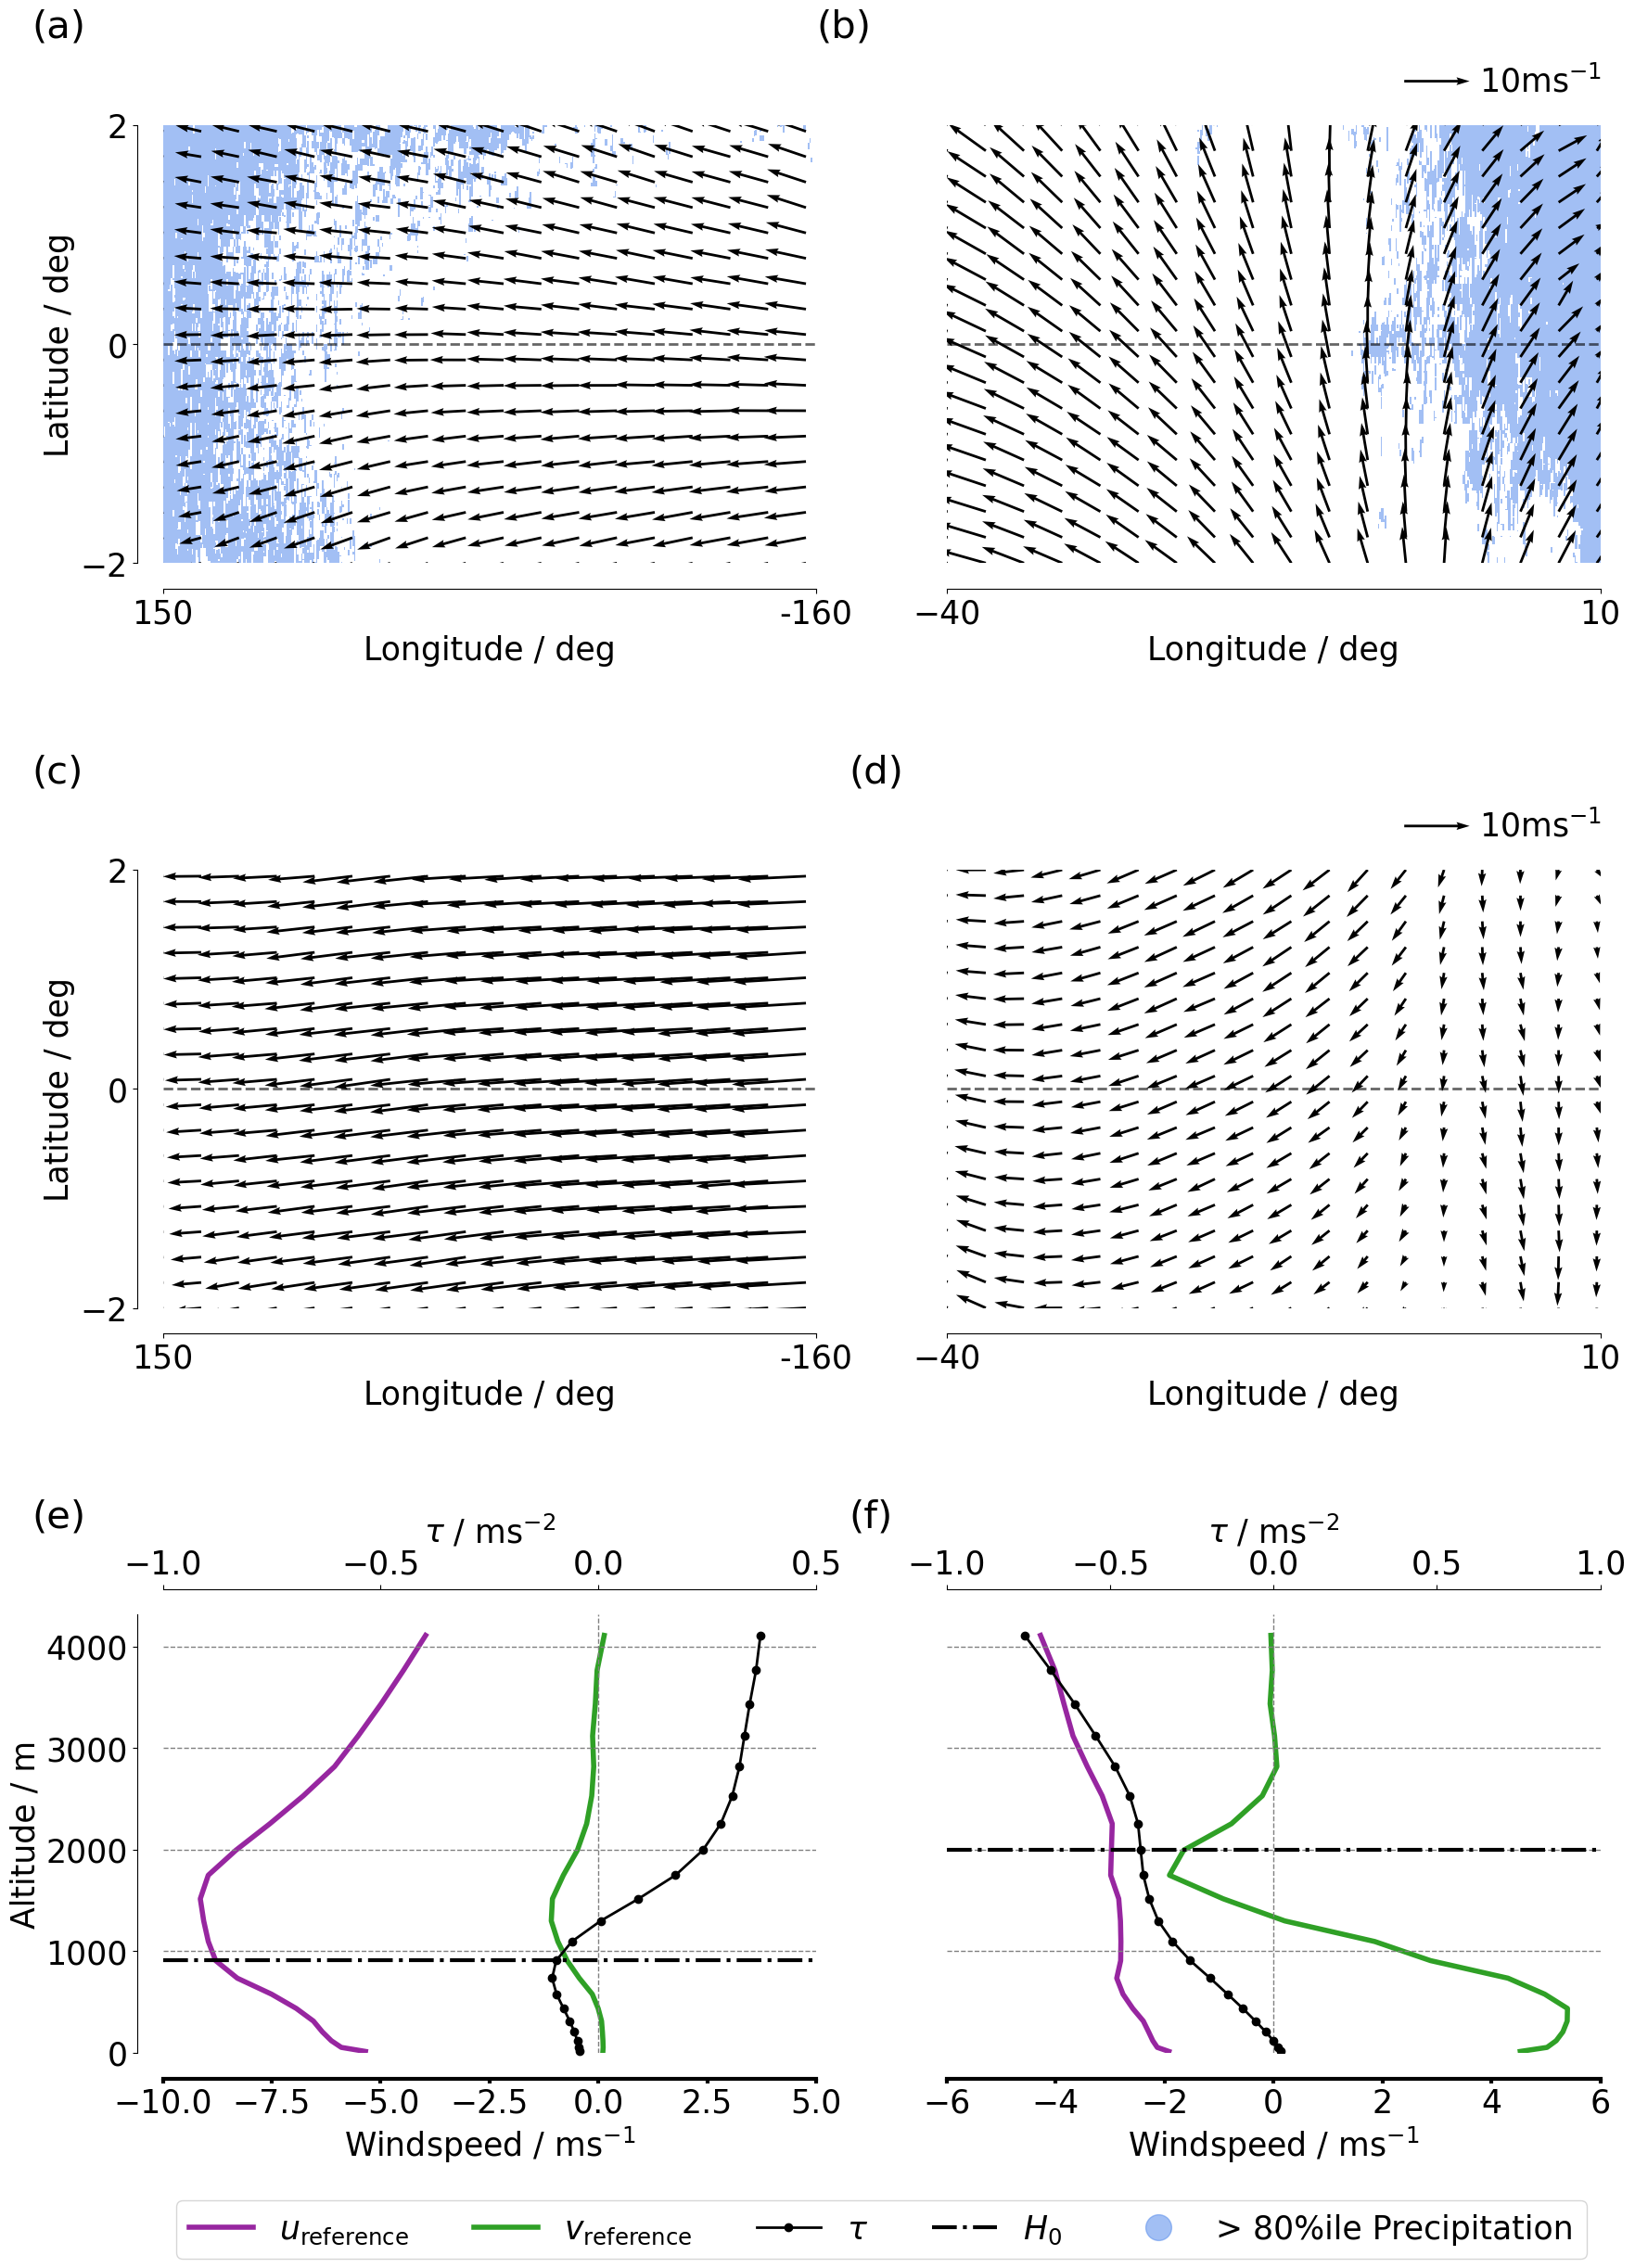

In [58]:
fig = plt.figure(figsize=(20,27), facecolor='w', edgecolor='k')
G = gridspec.GridSpec(3,2, hspace=0.7)

###############################################################  
###############################################################

ALPHA = 1

VMIN = -8
VMAX = 8

ax1 = plt.subplot(G[0,0])

ocean_type = 'western_pacific'
dpp        = 'ngc2009'
year       = '2020'
season     = "MAM"

degrees_lower_box_bound, degrees_upper_box_bound, degrees_left_box_bound, degrees_right_box_bound = choose_region(ocean_type)
print(ocean_type, 'with:', choose_region(ocean_type))

uu_sfc           = west_pcf_data.uu_valid_mask[0,:].sel(valid_mask_cells=west_pcf_two_to_two_mask)
vv_sfc           = west_pcf_data.vv_valid_mask[0,:].sel(valid_mask_cells=west_pcf_two_to_two_mask)

### western_pacific specialisation
if degrees_left_box_bound > degrees_right_box_bound:
    input_lon_values = np.rad2deg(wpcf_new_grid.clon.sel(cell=wpcf_valid).sel(cell=wpcf_mask).sel(cell=west_pcf_two_to_two_mask))
    lon_values       = xr.where(input_lon_values < 0, input_lon_values + 360, input_lon_values)

    uu_wind_ICON = xr.DataArray(west_pcf_data.uu_valid_mask.isel(height=0).sel(valid_mask_cells=west_pcf_two_to_two_mask),
                     coords={'clon': lon_values, 'clat': np.rad2deg(wpcf_new_grid.clat.sel(cell=wpcf_valid).sel(cell=wpcf_mask).sel(cell=west_pcf_two_to_two_mask))}, 
                     dims=['cell'], 
                     name="uu_wind_ICON")
    vv_wind_ICON = xr.DataArray(west_pcf_data.vv_valid_mask.isel(height=0).sel(valid_mask_cells=west_pcf_two_to_two_mask),
                     coords={'clon': lon_values, 'clat': np.rad2deg(wpcf_new_grid.clat.sel(cell=wpcf_valid).sel(cell=wpcf_mask).sel(cell=west_pcf_two_to_two_mask))}, 
                     dims=['cell'], 
                     name="vv_wind_ICON")
else:
    uu_wind_ICON    = xr.DataArray(west_pcf_data.uu_valid_mask.isel(height=0).sel(valid_mask_cells=west_pcf_two_to_two_mask),
                         coords={'clon': np.rad2deg(wpcf_new_grid.clon.sel(cell=wpcf_valid).sel(cell=wpcf_mask).sel(cell=west_pcf_two_to_two_mask)), 'clat': np.rad2deg(wpcf_new_grid.clat.sel(cell=wpcf_valid).sel(cell=wpcf_mask).sel(cell=west_pcf_two_to_two_mask))}, 
                         dims=['cell'], 
                         name="uu_wind_ICON")

    vv_wind_ICON   = xr.DataArray(west_pcf_data.vv_valid_mask.isel(height=0).sel(valid_mask_cells=west_pcf_two_to_two_mask),
                         coords={'clon': np.rad2deg(wpcf_new_grid.clon.sel(cell=wpcf_valid).sel(cell=wpcf_mask).sel(cell=west_pcf_two_to_two_mask)), 'clat': np.rad2deg(wpcf_new_grid.clat.sel(cell=wpcf_valid).sel(cell=wpcf_mask).sel(cell=west_pcf_two_to_two_mask))}, 
                         dims=['cell'], 
                         name="vv_wind_ICON")
    
### PRECIPITATION BACKGROUND
############################

# Plot the precipitation data as a background
precip_plot = ax1.pcolormesh(pr_wpcf_interp_lon, pr_wpcf_interp_lat, pr_wpcf_interp, 
                             cmap=cmap_two_c, norm=norm_two_c, alpha=0.6)

ax1.axhline(0, color='black', ls='dashed', lw=2, alpha=0.6)

ax1.set_xlim(150, 200)
ax1.set_xticks([150, 200])
ax1.set_xticklabels(['150', '-160'])
ax1.set_yticks([-2, 0, 2])
ax1.set_ylim(-2,2)
ax1.set_xlabel('Longitude / deg')
ax1.set_ylabel('Latitude / deg', rotation=90)
ax1.spines[['left', 'bottom']].set_position(('outward',20))
ax1.spines[['left', 'bottom']].set_visible(True)
ax1.spines[['right', 'top']].set_visible(False)


### QUIVER
##########

quiv_u_INPUT = interpolate_field_lon_lat(uu_wind_ICON, relative_resolution=0.05)
quiv_v_INPUT = interpolate_field_lon_lat(vv_wind_ICON, relative_resolution=0.05)

every = 4
Q1  = ax1.quiver(quiv_u_INPUT.lon[::every], quiv_u_INPUT.lat[::every], quiv_u_INPUT[::every,::every], quiv_v_INPUT[::every,::every], 
                 color='black', units='x', scale=2, width=0.2) #, scale=10)

ax1.text(-0.2, 1.2, '(a)', fontsize=30, transform=ax1.transAxes)

###############################################################  
###############################################################

ax1 = plt.subplot(G[1,0])

wpcf_top_of_ABL = seasons_df.loc[f'{ocean_type}'][f'{year}-{season}']
uu_sfc           = west_pcf_data.uu_valid_mask.sel(height=wpcf_top_of_ABL).sel(valid_mask_cells=west_pcf_two_to_two_mask)
vv_sfc           = west_pcf_data.vv_valid_mask.sel(height=wpcf_top_of_ABL).sel(valid_mask_cells=west_pcf_two_to_two_mask)

### western_pacific specialisation
if degrees_left_box_bound > degrees_right_box_bound:
    input_lon_values = np.rad2deg(wpcf_new_grid.clon.sel(cell=wpcf_valid).sel(cell=wpcf_mask).sel(cell=west_pcf_two_to_two_mask))
    lon_values       = xr.where(input_lon_values < 0, input_lon_values + 360, input_lon_values)

    uu_wind_ICON = xr.DataArray(west_pcf_data.uu_valid_mask.isel(height=wpcf_top_of_ABL).sel(valid_mask_cells=west_pcf_two_to_two_mask),
                     coords={'clon': lon_values, 'clat': np.rad2deg(wpcf_new_grid.clat.sel(cell=wpcf_valid).sel(cell=wpcf_mask).sel(cell=west_pcf_two_to_two_mask))}, 
                     dims=['cell'], 
                     name="uu_wind_ICON")
    vv_wind_ICON = xr.DataArray(west_pcf_data.vv_valid_mask.isel(height=wpcf_top_of_ABL).sel(valid_mask_cells=west_pcf_two_to_two_mask),
                     coords={'clon': lon_values, 'clat': np.rad2deg(wpcf_new_grid.clat.sel(cell=wpcf_valid).sel(cell=wpcf_mask).sel(cell=west_pcf_two_to_two_mask))}, 
                     dims=['cell'], 
                     name="vv_wind_ICON")
else:
    uu_wind_ICON    = xr.DataArray(west_pcf_data.uu_valid_mask.isel(height=wpcf_top_of_ABL).sel(valid_mask_cells=west_pcf_two_to_two_mask),
                         coords={'clon': np.rad2deg(wpcf_new_grid.clon.sel(cell=wpcf_valid).sel(cell=wpcf_mask).sel(cell=west_pcf_two_to_two_mask)), 'clat': np.rad2deg(wpcf_new_grid.clat.sel(cell=wpcf_valid).sel(cell=wpcf_mask).sel(cell=west_pcf_two_to_two_mask))}, 
                         dims=['cell'], 
                         name="uu_wind_ICON")

    vv_wind_ICON   = xr.DataArray(west_pcf_data.vv_valid_mask.isel(height=wpcf_top_of_ABL).sel(valid_mask_cells=west_pcf_two_to_two_mask),
                         coords={'clon': np.rad2deg(wpcf_new_grid.clon.sel(cell=wpcf_valid).sel(cell=wpcf_mask).sel(cell=west_pcf_two_to_two_mask)), 'clat': np.rad2deg(wpcf_new_grid.clat.sel(cell=wpcf_valid).sel(cell=wpcf_mask).sel(cell=west_pcf_two_to_two_mask))}, 
                         dims=['cell'], 
                         name="vv_wind_ICON")

### COLORMAP
############

ax1.axhline(0, color='black', ls='dashed', lw=2, alpha=0.6)

ax1.set_xlim(150, 200)
ax1.set_xticks([150, 200])
ax1.set_xticklabels(['150', '-160'])
ax1.set_yticks([-2, 0, 2])
ax1.set_ylim(-2,2)
ax1.set_xlabel('Longitude / deg')
ax1.set_ylabel('Latitude / deg', rotation=90)
ax1.spines[['left', 'bottom']].set_position(('outward',20))
ax1.spines[['left', 'bottom']].set_visible(True)
ax1.spines[['right', 'top']].set_visible(False)


### QUIVER
##########

quiv_u_INPUT = interpolate_field_lon_lat(uu_wind_ICON, relative_resolution=0.05)
quiv_v_INPUT = interpolate_field_lon_lat(vv_wind_ICON, relative_resolution=0.05)

every = 4
Q3  = ax1.quiver(quiv_u_INPUT.lon[::every], quiv_u_INPUT.lat[::every], quiv_u_INPUT[::every,::every], quiv_v_INPUT[::every,::every], 
                 color='black', units='x', scale=2, width=0.2) #, scale=10)

ax1.text(-0.2, 1.2, '(c)', fontsize=30, transform=ax1.transAxes)

###############################################################  
###############################################################

ax2 = plt.subplot(G[2,0])
ax22 = ax2.twiny()

ax2.axhline(y = 1000, color = 'grey', linestyle = '--', lw=1, zorder=3)
ax2.axhline(y = 2000, color = 'grey', linestyle = '--', lw=1, zorder=3)
ax2.axhline(y = 3000, color = 'grey', linestyle = '--', lw=1, zorder=3)
ax2.axhline(y = 4000, color = 'grey', linestyle = '--', lw=1, zorder=3)

ax2.axvline(x = 0, color = 'grey', linestyle = '--', lw=1, zorder=3)

#ax2.plot(ua_wpcf.uu.mean(dim='all_cells'), mean_cell_height[:21],
#         color='#9726A0', label=r'$u_{\mathrm{reference}}$', linestyle='solid', lw=4, zorder=2, alpha=1)
#ax2.plot(va_wpcf.vv.mean(dim='all_cells'), mean_cell_height[:21],
#         color='#2FA026', label=r'$v_{\mathrm{reference}}$', linestyle='solid', lw=4, zorder=2, alpha=ALPHA)
#ax2.plot((ua_wpcf.uu.mean(dim='all_cells')**2+va_wpcf.vv.mean(dim='all_cells')**2)**(0.5), mean_cell_height[:21],
#         color='grey', label=r'$u_{\mathrm{reference}}$', linestyle='solid', lw=4, zorder=2, alpha=1)

ax2.plot(west_pcf_data.uu_valid_mask.sel(valid_mask_cells=west_pcf_two_to_two_mask).mean(dim='valid_mask_cells'), mean_cell_height[:21],
         color='#9726A0', label=r'$u_{\mathrm{reference}}$', linestyle='solid', lw=4, zorder=2, alpha=1)
ax2.plot(west_pcf_data.vv_valid_mask.sel(valid_mask_cells=west_pcf_two_to_two_mask).mean(dim='valid_mask_cells'), mean_cell_height[:21],
         color='#2FA026', label=r'$v_{\mathrm{reference}}$', linestyle='solid', lw=4, zorder=2, alpha=ALPHA)

ax2.axhline(y = mean_cell_height[wpcf_top_of_ABL].values, color = 'black', linestyle = '-.', lw=3, zorder=3, label=r'$H_0$')

ax2.set_xlim(-10,5)
ax2.set_ylabel('Altitude / m')
ax2.set_xlabel(r'Windspeed / $\mathrm{ms}^{-1}$')
ax2.set_ylim(bottom=0)
ax2.set_yticks([0, 1000, 2000, 3000, 4000])
ax2.spines[['top', 'right']].set_visible(False)
ax2.spines[['left','bottom']].set_position(('outward',20))
ax2.spines['bottom'].set_linewidth(3)
ax2.tick_params(axis='x', width=3)

ax22.plot(wpcf_total_turb_stress_mom, mean_cell_height[:21],
     marker='o', linestyle='-', color='black', ms=6, lw=2, clip_on=False, label=r'$\tau$')
#ax22.plot(wpcf_total_turb_stress_mom[wpcf_top_of_ABL], mean_cell_height[wpcf_top_of_ABL],
#          marker='o', linestyle='None', markerfacecolor='none', markeredgecolor='red', ms=20, clip_on=False, label=r'$H_0$')

ax22.set_xlim(-1,0.5)
ax22.spines[['left', 'bottom', 'right']].set_visible(False)
ax22.spines[['top']].set_visible(True)
ax22.spines[['top']].set_position(('outward',20))
ax22.set_xlabel(r'$\tau$ / $\mathrm{ms}^{-2}$')
ax22.set_xticks([-1,-0.5,0,0.5])
#ax22.spines['top'].set_linewidth(2)

#fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.05), fancybox=True, shadow=False, ncol=5)

ax2.text(-0.2, 1.2, '(e)', fontsize=30, transform=ax2.transAxes)

##############################################################################################################################  
##############################################################################################################################

ax3 = plt.subplot(G[0,1])

ocean_type = 'atlantic'
dpp        = 'ngc2009'
year       = '2020'
season     = "SON"

degrees_lower_box_bound, degrees_upper_box_bound, degrees_left_box_bound, degrees_right_box_bound = choose_region(ocean_type)
print(ocean_type, 'with:', choose_region(ocean_type))

uu_sfc           = atl_data.uu_valid_mask[0,:].sel(valid_mask_cells=atl_two_to_two_mask)
vv_sfc           = atl_data.vv_valid_mask[0,:].sel(valid_mask_cells=atl_two_to_two_mask)

### western_pacific specialisation
if degrees_left_box_bound > degrees_right_box_bound:
    input_lon_values = np.rad2deg(atl_new_grid.clon.sel(cell=atl_valid).sel(cell=atl_mask).sel(cell=atl_two_to_two_mask))
    lon_values       = xr.where(input_lon_values < 0, input_lon_values + 360, input_lon_values)

    uu_wind_ICON = xr.DataArray(atl_data.uu_valid_mask.isel(height=0).sel(valid_mask_cells=atl_two_to_two_mask),
                     coords={'clon': lon_values, 'clat': np.rad2deg(atl_new_grid.clat.sel(cell=atl_valid).sel(cell=atl_mask).sel(cell=atl_two_to_two_mask))}, 
                     dims=['cell'], 
                     name="uu_wind_ICON")
    vv_wind_ICON = xr.DataArray(atl_data.vv_valid_mask.isel(height=0).sel(valid_mask_cells=atl_two_to_two_mask),
                     coords={'clon': lon_values, 'clat': np.rad2deg(atl_new_grid.clat.sel(cell=atl_valid).sel(cell=atl_mask).sel(cell=atl_two_to_two_mask))}, 
                     dims=['cell'], 
                     name="vv_wind_ICON")
else:
    uu_wind_ICON    = xr.DataArray(atl_data.uu_valid_mask.isel(height=0).sel(valid_mask_cells=atl_two_to_two_mask),
                         coords={'clon': np.rad2deg(atl_new_grid.clon.sel(cell=atl_valid).sel(cell=atl_mask).sel(cell=atl_two_to_two_mask)), 'clat': np.rad2deg(atl_new_grid.clat.sel(cell=atl_valid).sel(cell=atl_mask).sel(cell=atl_two_to_two_mask))}, 
                         dims=['cell'], 
                         name="uu_wind_ICON")

    vv_wind_ICON   = xr.DataArray(atl_data.vv_valid_mask.isel(height=0).sel(valid_mask_cells=atl_two_to_two_mask),
                         coords={'clon': np.rad2deg(atl_new_grid.clon.sel(cell=atl_valid).sel(cell=atl_mask).sel(cell=atl_two_to_two_mask)), 'clat': np.rad2deg(atl_new_grid.clat.sel(cell=atl_valid).sel(cell=atl_mask).sel(cell=atl_two_to_two_mask))}, 
                         dims=['cell'], 
                         name="vv_wind_ICON")
    
### PRECIPITATION BACKGROUND
############################

# Plot the precipitation data as a background
precip_plot = ax3.pcolormesh(pr_atl_interp_lon, pr_atl_interp_lat, pr_atl_interp, 
                             cmap=cmap_two_c, norm=norm_two_c, alpha=0.6)

ax3.axhline(0, color='black', ls='dashed', lw=2, alpha=0.6)

ax3.set_yticks([-2, 0, 2])
ax3.set_ylim(-2,2)
ax3.set_xlabel('Longitude / deg')
ax3.set_ylabel('Latitude / deg', rotation=90)
ax3.spines[['left', 'bottom']].set_position(('outward',20))
ax3.spines[['left', 'bottom']].set_visible(True)

### western_pacific specialisation
if degrees_left_box_bound > degrees_right_box_bound:
    ax3.set_xlim(degrees_left_box_bound, degrees_left_box_bound+50)
    ax3.set_xticks([150, 200])
    ax3.set_xticklabels(['150', '-160'])
else:
    ax3.set_xlim(degrees_left_box_bound, degrees_right_box_bound)
    ax3.set_xticks([degrees_left_box_bound, degrees_right_box_bound])

ax3.spines[['left', 'right', 'bottom']].set_position(('outward',20))
ax3.spines[['left', 'top', 'right']].set_visible(False)
ax3.spines['left'].set_color('white') 
ax3.tick_params(axis='y', labelcolor='white', color='white')
ax3.yaxis.label.set_color('white') 

### QUIVER
##########

quiv_u_INPUT = interpolate_field_lon_lat(uu_wind_ICON, relative_resolution=0.05)
quiv_v_INPUT = interpolate_field_lon_lat(vv_wind_ICON, relative_resolution=0.05)

every = 4
Q2  = ax3.quiver(quiv_u_INPUT.lon[::every], quiv_u_INPUT.lat[::every], quiv_u_INPUT[::every,::every], quiv_v_INPUT[::every,::every], 
                 color='black', units='x', scale=2, width=0.2) #, scale=10)
ax3.quiverkey(Q1, 2, 1.1, 10, r'$10 \mathrm{ms}^{-1}$', labelpos='E', coordinates='axes', animated=True, fontproperties={'size':SIZE})

ax3.text(-0.2, 1.2, '(b)', fontsize=30, transform=ax3.transAxes)

###############################################################  
###############################################################

ax3 = plt.subplot(G[1,1])

atl_top_of_ABL = seasons_df.loc[f'{ocean_type}'][f'{year}-{season}']
uu_sfc           = atl_data.uu_valid_mask.isel(height=atl_top_of_ABL).sel(valid_mask_cells=atl_two_to_two_mask)
vv_sfc           = atl_data.vv_valid_mask.isel(height=atl_top_of_ABL).sel(valid_mask_cells=atl_two_to_two_mask)
### western_pacific specialisation
if degrees_left_box_bound > degrees_right_box_bound:
    input_lon_values = np.rad2deg(atl_new_grid.clon.sel(cell=atl_valid).sel(cell=atl_mask).sel(cell=atl_two_to_two_mask))
    lon_values       = xr.where(input_lon_values < 0, input_lon_values + 360, input_lon_values)

    uu_wind_ICON = xr.DataArray(atl_data.uu_valid_mask.isel(height=atl_top_of_ABL).sel(valid_mask_cells=atl_two_to_two_mask),
                     coords={'clon': lon_values, 'clat': np.rad2deg(atl_new_grid.clat.sel(cell=atl_valid).sel(cell=atl_mask).sel(cell=atl_two_to_two_mask))}, 
                     dims=['cell'], 
                     name="uu_wind_ICON")
    vv_wind_ICON = xr.DataArray(atl_data.vv_valid_mask.isel(height=atl_top_of_ABL).sel(valid_mask_cells=atl_two_to_two_mask),
                     coords={'clon': lon_values, 'clat': np.rad2deg(atl_new_grid.clat.sel(cell=atl_valid).sel(cell=atl_mask).sel(cell=atl_two_to_two_mask))}, 
                     dims=['cell'], 
                     name="vv_wind_ICON")
else:
    uu_wind_ICON    = xr.DataArray(atl_data.uu_valid_mask.isel(height=atl_top_of_ABL).sel(valid_mask_cells=atl_two_to_two_mask),
                         coords={'clon': np.rad2deg(atl_new_grid.clon.sel(cell=atl_valid).sel(cell=atl_mask).sel(cell=atl_two_to_two_mask)), 'clat': np.rad2deg(atl_new_grid.clat.sel(cell=atl_valid).sel(cell=atl_mask).sel(cell=atl_two_to_two_mask))}, 
                         dims=['cell'], 
                         name="uu_wind_ICON")

    vv_wind_ICON   = xr.DataArray(atl_data.vv_valid_mask.isel(height=atl_top_of_ABL).sel(valid_mask_cells=atl_two_to_two_mask),
                         coords={'clon': np.rad2deg(atl_new_grid.clon.sel(cell=atl_valid).sel(cell=atl_mask).sel(cell=atl_two_to_two_mask)), 'clat': np.rad2deg(atl_new_grid.clat.sel(cell=atl_valid).sel(cell=atl_mask).sel(cell=atl_two_to_two_mask))}, 
                         dims=['cell'], 
                         name="vv_wind_ICON")
    
    
### COLORMAP
############

INPUT = interpolate_field_lon_lat(uu_wind_ICON)
lon_INPUT, lat_INPUT = np.meshgrid(INPUT.lon, INPUT.lat)

### western_pacific specialisation
if degrees_left_box_bound > degrees_right_box_bound:
    ax3.set_xlim(degrees_left_box_bound, degrees_left_box_bound+50)
    ax3.set_xticks([150, 200])
    ax3.set_xticklabels(['150', '-160'])
else:
    ax3.set_xlim(degrees_left_box_bound, degrees_right_box_bound)
    ax3.set_xticks([degrees_left_box_bound, degrees_right_box_bound])

ax3.axhline(0, color='black', ls='dashed', lw=2, alpha=0.6)

INPUT = interpolate_field_lon_lat(vv_wind_ICON, relative_resolution=0.05)
lon_INPUT, lat_INPUT = np.meshgrid(INPUT.lon, INPUT.lat)

ax3.set_yticks([-2, 0, 2])
ax3.set_ylim(-2,2)
ax3.set_xlabel('Longitude / deg')
ax3.set_ylabel('Latitude / deg', rotation=90)
ax3.spines[['left', 'bottom']].set_position(('outward',20))
ax3.spines[['left', 'bottom']].set_visible(True)


ax3.spines[['left', 'right', 'bottom']].set_position(('outward',20))
ax3.spines[['left', 'top', 'right']].set_visible(False)
ax3.spines['left'].set_color('white') 
ax3.tick_params(axis='y', labelcolor='white', color='white')
ax3.yaxis.label.set_color('white') 

### QUIVER
##########

quiv_u_INPUT = interpolate_field_lon_lat(uu_wind_ICON, relative_resolution=0.05)
quiv_v_INPUT = interpolate_field_lon_lat(vv_wind_ICON, relative_resolution=0.05)

every = 4
Q4  = ax3.quiver(quiv_u_INPUT.lon[::every], quiv_u_INPUT.lat[::every], quiv_u_INPUT[::every,::every], quiv_v_INPUT[::every,::every], 
                 color='black', units='x', scale=2, width=0.2) #, scale=10)
ax3.quiverkey(Q3, 2, 1.1, 10, r'$10 \mathrm{ms}^{-1}$', labelpos='E', coordinates='axes', animated=True, fontproperties={'size':SIZE})

ax3.text(-0.15, 1.2, '(d)', fontsize=30, transform=ax3.transAxes)

###############################################################  
###############################################################

ax4 = plt.subplot(G[2,1])
ax44 = ax4.twiny()

ax4.axhline(y = 1000, color = 'grey', linestyle = '--', lw=1, zorder=3)
ax4.axhline(y = 2000, color = 'grey', linestyle = '--', lw=1, zorder=3)
ax4.axhline(y = 3000, color = 'grey', linestyle = '--', lw=1, zorder=3)
ax4.axhline(y = 4000, color = 'grey', linestyle = '--', lw=1, zorder=3)
ax4.axvline(x = 0, color = 'grey', linestyle = '--', lw=1, zorder=3)

h0 = ax4.axhline(y = mean_cell_height[atl_top_of_ABL].values, color = 'black', linestyle = '-.', lw=3, zorder=3, label=r'$H_0$')

#uref, = ax4.plot(ua_atl.uu.mean(dim='all_cells'), mean_cell_height[:21],
#         color='#9726A0', label=r'$u_{\mathrm{ICON}}$', linestyle='solid', lw=4, zorder=2, alpha=ALPHA)
#uref, = ax4.plot(va_atl.vv.mean(dim='all_cells'), mean_cell_height[:21],
#         color='#2FA026', label=r'$v_{\mathrm{ICON}}$', linestyle='solid', lw=4, zorder=2, alpha=1)

uref, = ax4.plot(atl_data.uu_valid_mask.sel(valid_mask_cells=atl_two_to_two_mask).mean(dim='valid_mask_cells'), mean_cell_height[:21],
         color='#9726A0', label=r'$u_{\mathrm{ICON}}$', linestyle='solid', lw=4, zorder=2, alpha=ALPHA)
vref, = ax4.plot(atl_data.vv_valid_mask.sel(valid_mask_cells=atl_two_to_two_mask).mean(dim='valid_mask_cells'), mean_cell_height[:21],
         color='#2FA026', label=r'$v_{\mathrm{ICON}}$', linestyle='solid', lw=4, zorder=2, alpha=1)

#uvref, = ax4.plot((ua_atl.uu.mean(dim='all_cells')**2 + va_atl.vv.mean(dim='all_cells')**2)**(0.5), mean_cell_height[:21],
#         color='grey', label=r'$uv_{\mathrm{ICON}}$', linestyle='solid', lw=4, zorder=2, alpha=ALPHA)

ax4.set_xlim(-6,6)
ax4.set_xlabel(r'Windspeed / $\mathrm{ms}^{-1}$')
ax4.set_yticks([])
ax4.set_yticklabels([])
ax4.set_ylim(bottom=0)
ax4.spines[['left', 'top', 'right']].set_visible(False)
ax4.spines[['left','bottom']].set_position(('outward',20))
ax4.spines['bottom'].set_linewidth(3)
ax4.tick_params(axis='x', width=3)

tau, = ax44.plot(atl_total_turb_stress_mom, mean_cell_height[:21],
     marker='o', linestyle='-', color='black', ms=6, lw=2, label=r'$\tau$')
#ax44.plot(atl_total_turb_stress_mom[atl_top_of_ABL], mean_cell_height[atl_top_of_ABL],
#          marker='o', linestyle='None', markerfacecolor='none', markeredgecolor='red', ms=20, label=r'$H_0$')

ax44.set_xlim(-1,1)
ax44.spines[['left', 'bottom', 'right']].set_visible(False)
ax44.spines[['top']].set_visible(True)
ax44.spines[['top']].set_position(('outward',20))
ax44.set_xlabel(r'$\tau$ / $\mathrm{ms}^{-2}$')
ax44.set_xticks([-1,-0.5,0,0.5, 1])
#ax44.spines['top'].set_linewidth(2)

ax4.text(-0.15, 1.2, '(f)', fontsize=30, transform=ax4.transAxes)

# Create a proxy artist for the pcolormesh and add it to the legend
proxy_artist = Line2D([0], [0], linestyle="none", marker='o', color=cmap_two_c(0.5), alpha=0.6, ms=20, label='80%ile Precipitation')
ax4.legend([uref, vref, tau, h0, proxy_artist], [r'$u_{\mathrm{reference}}$', r'$v_{\mathrm{reference}}$', r'$\tau$', r'$H_0$', '> 80%ile Precipitation'],
           loc='upper center', bbox_to_anchor=(-0.1, -0.3), fancybox=True, shadow=False, ncol=5)

plt.tight_layout()

filename = f'fig_02_revised.pdf'
filepath = 'figs_review/'
plt.savefig(filepath + filename, facecolor='white', bbox_inches='tight', dpi=400)

plt.show()